# Chapter 3. word2vec

신경망으로 단어들을 벡터로 표현해보자!

## CBOW (continuous bag-ofwords) 모델

맥락으로부터 타깃을 추측하는 신경망.<br>
입력층 (맥락) - 은닉층 - 출력층 (점수)<br>
- Input : 맥락. (맥락에 넣는 단어가 2개라면 입력층이 2개, N개면 N개) (단어들의 목록, one-hot encoded)
- Hidden : 입력층 별 변환값을 평균냄.
- Output : 점수. (단어 별 점수가 나오고, 가장 높은 점수를 타깃으로 여김.) => Softmax 함수로 확률로 변환.

입력-은닉층의 weight $\text{W}_{in}$의 각 행이 해당 단어의 분산표현에 해당된다.

**NOTE: 은닉층의 노드 갯수 = 분산화된 단어 벡터의 차원**

In [1]:
# CBOW model (toy)
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

c0 = np.array([1,0,0,0,0,0,0])
c1 = np.array([0,0,1,0,0,0,0])

W_in = np.random.randn(7,3)
W_out = np.random.randn(3,7)

in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

[-2.09809243 -0.50619147  0.36804992  1.18021091  0.93013962  0.95428948
 -1.38395563]


In [2]:
# 맥락 생성하기
import sys
sys.path.append('..')
from common.util import preprocess, create_contexts_target

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [3]:
contexts, target = create_contexts_target(corpus, window_size=1)

print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [4]:
from common.util import convert_one_hot

vocab_size = len(word_to_id)
target = convert_one_hot(target,vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [5]:
# Class CBOW
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:,0])
        h1 = self.in_layer1.forward(contexts[:,1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score,target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

/Users/shong/miniforge3/envs/tf2/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/shong/miniforge3/envs/tf2/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/shong/miniforge3/envs/tf2/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/shong/miniforge3/envs/tf2/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


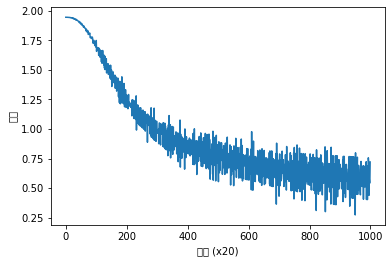

you [ 1.3013543 -1.0315956 -1.1006812 -1.126467  -1.1246048]
say [0.04854178 1.1693751  1.1447225  1.1588452  1.1718055 ]
goodbye [ 0.69197637 -0.85705364 -0.7876438  -0.7070746  -0.704183  ]
and [2.0087755  0.82743144 0.9016166  0.85000956 0.8732831 ]
i [ 0.6944755  -0.85109204 -0.7905701  -0.71165127 -0.7167074 ]
hello [ 1.2983407 -1.0330712 -1.0989636 -1.1205229 -1.1428335]
. [-1.6847807  1.147923   1.130904   1.1539146  1.1878074]


In [6]:
# CBOW 학습
import sys
sys.path.append('..') 
from common.trainer import Trainer
from common.optimizer import Adam
from simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot


window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

CBOW와는 반대로, 중앙 단어로부터 주변 맥락을
유추하는 **skip-gram** model도 있음. <br>
(구조는 CBOW를 앞뒤로 뒤집으면 됨.) <br>
(따로 python 파일을 github로부터 저장함.)